In [111]:
#import modules
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from sklearn.preprocessing import LabelEncoder
import re
import plotly.express as px
import warnings

pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
%matplotlib inline
warnings.filterwarnings('ignore')

**Total Suspended Solids**\
`TSS(mg/L) = W2-Wc / Vol of Sample * 100`

**Calcium Hardness**\
`Calcium Hardness, MgCaCO3 l = (A-B)*c*1000 / volume of Sample`\
`Calcium, mg/l = (A-B)*c*400.8 / volume of sample`\
where:

A is Volume of EDTA used for sample\
B is Volume of EDTA used for blank\
C is mgCaCO3equivalent to 1.00(ml) EDTA solution calcium\
mg/L =0.43 x 1

**Dissolved Oxygen** 

`DO (mg) = (ml titrant)*N*8*1000 / Sample voulme in ml`\
where:

ml titrant is volume of Na2SO2O3 used in titration\
N is Normality of Na2SO2O3\
1000 is Conversion factor to I liter\
8 is Oxidation power of oxygen (mg) equal to 1 milliequivalent of K2Cr2O7


**Chemical Oxygen Demand (COD)**

`COD, mg/L = (A-B) N x 8000 / S`\
where:

A is titer value of the blank\
B is titer value of the sample\
N is normality of the Fe (NH4)2(SO4)2 solution\
S is volume of sample


Water samples were collected from five different coordinates around the dumpsite and were labelled (W1, W2, W3, C1, L1) 

**Data Collection**

Data were carefully collected from the sample taken from identified sample points


In [112]:
#Load data
aquifer_physiochem = pd.read_excel("C:/Users/admin/Documents/Manuscript/Aquifer-vulnerability/data/Aquifer-vulnerability.xlsx", sheet_name=2)
ves_coordinates = pd.read_excel("C:/Users/admin/Documents/Manuscript/Aquifer-vulnerability/data/Aquifer-vulnerability.xlsx", sheet_name=1)

`self note`

`Data analysis strategy`,\
perform data cleaning for physiochemical param and ves station\
extraplolate physiochemical params.

`for Machine learning`\
Use clustering algorithm

In [113]:
ves_coordinates 
#drop column unnamed, the clustering will be done along the coordinates

,Unnamed: 0,Station,Elevation (ft),Coordinate East,Coordinate North
0,NaN,1,161/157,6° 47'54.4'',6°06'11.6''
1,NaN,2,146,6°47'59.1'',6°06'53''
2,NaN,3,150,6°48'03.7'',6°06'05.1''
3,NaN,4,162,6°47'55.5'',6°06'14.1''
4,NaN,5,36,6°47'54.14'',6°06'16.7''
5,NaN,6,166,6°47'7.13'',6°06'3.81''
6,NaN,7,163,6°47'7.8'',6°06'2.07''
7,NaN,8,144,6°47'7.84'',6°06'2.12''
8,NaN,9,132,6°47'7.82'',6°06'1.52''
9,NaN,10,156,6°47'1.08'',6°06'1.26''


**Data cleaning for ves coordinate dataframe.**

In [114]:
ves_coordinates.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10 entries, 0 to 9
Data columns (total 5 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   Unnamed: 0        0 non-null      float64
 1   Station           10 non-null     int64  
 2   Elevation (ft)    10 non-null     object 
 3   Coordinate East   10 non-null     object 
 4   Coordinate North  10 non-null     object 
dtypes: float64(1), int64(1), object(3)
memory usage: 528.0+ bytes


In [115]:
ves_coordinates = ves_coordinates.drop(columns=['Unnamed: 0'])
ves_coordinates

,Station,Elevation (ft),Coordinate East,Coordinate North
0,1,161/157,6° 47'54.4'',6°06'11.6''
1,2,146,6°47'59.1'',6°06'53''
2,3,150,6°48'03.7'',6°06'05.1''
3,4,162,6°47'55.5'',6°06'14.1''
4,5,36,6°47'54.14'',6°06'16.7''
5,6,166,6°47'7.13'',6°06'3.81''
6,7,163,6°47'7.8'',6°06'2.07''
7,8,144,6°47'7.84'',6°06'2.12''
8,9,132,6°47'7.82'',6°06'1.52''
9,10,156,6°47'1.08'',6°06'1.26''


In [116]:
def dms_to_decimal(dms):
    try:
        pattern = re.compile(r'(\d+)[°\s]+(\d+)[\'\s]+([\d\.])+["\s]*')
        match = pattern.match(dms)
        if match:
            degrees, minutes, seconds = map(float, match.groups())
            decimal_degrees = degrees + minutes/60 + seconds/3600
            return decimal_degrees
        else:
            return None
    except Exception as e:
        print(f"error occured while changing to decimal: {e}")
        raise e

In [117]:
ves_coordinates['Coordinate East'] = ves_coordinates['Coordinate East'].apply(dms_to_decimal)
ves_coordinates['Coordinate North'] = ves_coordinates['Coordinate North'].apply(dms_to_decimal)

ves_coordinates

,Station,Elevation (ft),Coordinate East,Coordinate North
0,1,161/157,6.784444,6.101667
1,2,146,6.783611,6.100833
2,3,150,6.801944,6.100278
3,4,162,6.784722,6.100278
4,5,36,6.784444,6.101944
5,6,166,6.784167,6.100278
6,7,163,6.785556,6.101944
7,8,144,6.784444,6.100556
8,9,132,6.783889,6.100556
9,10,156,6.785556,6.101667


In [118]:
ves_coordinates.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10 entries, 0 to 9
Data columns (total 4 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   Station           10 non-null     int64  
 1   Elevation (ft)    10 non-null     object 
 2   Coordinate East   10 non-null     float64
 3   Coordinate North  10 non-null     float64
dtypes: float64(2), int64(1), object(1)
memory usage: 448.0+ bytes


In [119]:
def parse_dataframe(elevation):
    try:
        if '/' in str(elevation):
            parts = elevation.split('/')
            return sum(map(int, parts)) // len(parts)
        else:
            return int(elevation)
    except Exception as e:
        print(f"Error while trying to parse the dataframe: {e}")
        raise e

In [120]:
ves_coordinates['Elevation (ft)'] = ves_coordinates['Elevation (ft)'].apply(parse_dataframe)

ves_coordinates

,Station,Elevation (ft),Coordinate East,Coordinate North
0,1,159,6.784444,6.101667
1,2,146,6.783611,6.100833
2,3,150,6.801944,6.100278
3,4,162,6.784722,6.100278
4,5,36,6.784444,6.101944
5,6,166,6.784167,6.100278
6,7,163,6.785556,6.101944
7,8,144,6.784444,6.100556
8,9,132,6.783889,6.100556
9,10,156,6.785556,6.101667


In [121]:
ves_coordinates.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10 entries, 0 to 9
Data columns (total 4 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   Station           10 non-null     int64  
 1   Elevation (ft)    10 non-null     int64  
 2   Coordinate East   10 non-null     float64
 3   Coordinate North  10 non-null     float64
dtypes: float64(2), int64(2)
memory usage: 448.0 bytes


In [122]:
#save cleaned dataframe
ves_coordinates.to_csv('C:/Users/admin/Documents/Manuscript/Aquifer-vulnerability/data/ves_coordinates.csv')

**Data Cleaning**

**Data cleaning for aquifer physiochemical dataframe.**

In [123]:
aquifer_physiochem
#remove unwanted rows and heading.

,Unnamed: 0,Unnamed: 1,Unnamed: 2,Unnamed: 3,Unnamed: 4,Unnamed: 5,Unnamed: 6,Unnamed: 7,Unnamed: 8
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,S/N,PARAMETERS,W1,W2,W3,C1,L1,Mean,NSDWQ
2,1,pH,5.7,5.2,5.5,5.9,7.1,5.88,6.5-8.5
3,2,Salinity (mg/L),50,45,16,15,1200,265.2,NS
4,3,DO (mg/L),6.4,6.6,6.5,6.5,6.9,6.58,6.5 -8
5,4,BOD5(mg/L),1.12,1.08,1.06,1.03,2.14,1.286,NS
6,5,Chloride (mg/L),18.46,16.15,6.92,6.92,253.83,60.456,100
7,6,Carbonate(mg/L),0,0,0,0,0,0,NS
8,7,Sulphate (mg/L),22,13,0,0,30,13,100
9,8,Magnesium (mg/L),4.115,3.782,2.464,4.439,32.349,9.4298,100


In [124]:
aquifer_physiochem = aquifer_physiochem.rename(columns={'Unnamed: 0':'S/N','Unnamed: 1':'PARAMETERS','Unnamed: 2':'W1',	'Unnamed: 3':'W2','Unnamed: 4':'W3','Unnamed: 5':'C1','Unnamed: 6':'L1','Unnamed: 7':'Mean','Unnamed: 8':'NSDWQ'})

aquifer_physiochem = aquifer_physiochem.drop(index=[0,1])

In [125]:
aquifer_physiochem.reset_index(drop=True, inplace=True)

aquifer_physiochem.drop(columns=['S/N'], inplace=True)

In [126]:
aquifer_physiochem.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18 entries, 0 to 17
Data columns (total 8 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   PARAMETERS  18 non-null     object
 1   W1          18 non-null     object
 2   W2          18 non-null     object
 3   W3          18 non-null     object
 4   C1          18 non-null     object
 5   L1          18 non-null     object
 6   Mean        18 non-null     object
 7   NSDWQ       18 non-null     object
dtypes: object(8)
memory usage: 1.2+ KB


In [127]:
#Identifying uniques values
for col in aquifer_physiochem.select_dtypes(include=['object']).columns:
    print(f"{col}:{aquifer_physiochem[col].unique()}")


PARAMETERS:['pH ' 'Salinity (mg/L) ' 'DO (mg/L)' 'BOD5(mg/L)' 'Chloride (mg/L)'
 'Carbonate(mg/L) ' 'Sulphate (mg/L)' 'Magnesium (mg/L)' 'Calcium (mg/L)'
 'Potassium(mg/L) ' 'Lead (mg/L)' 'Mecury(mg/L) ' 'Chromium(mg/L) '
 'Iron (mg/L)' 'TSS(mg/L)' 'TDS(mg/L)' 'EC(µs/cm)' 'TurbidityN(TU)']
W1:[5.7 50 6.4 1.12 18.46 0 22 4.115 1.571 3.81 '<0.001 ' 'N.D ' 0.339 0.06
 118 230]
W2:[5.2 45 6.6 1.08 16.15 0 13 3.782 0.163 3.089 '<0.001 ' 'N.D ' 0.049 0.12
 77 152]
W3:[5.5 16 6.5 1.06 6.92 0 2.464 '<0.001 ' 0.552 'N.D ' 0.116 0.02 35 68]
C1:[5.9 15 6.5 1.03 6.92 0 4.439 0.215 0.122 '<0.001 ' 'N.D ' 0.187 0.04 27
 46]
L1:[7.1 1200 6.9 2.14 253.83 0 30 32.349 33.386 32.7 0.013 'N.D ' '<0.001 '
 1.299 0.26 1786 3680 29.8]
Mean:[5.88 265.2 6.58 1.286 60.456 0 13 9.4298 8.83375 8.0546 0.013 'N.D' 0.001
 0.398 0.1 408.6 835.2 5.96]
NSDWQ:['6.5-8.5' 'NS' '6.5 -8' 100 150 '1-2' 0.01 'N.D' 0.05 '0.05-0.3  ' 500
 1000 5]


In [128]:
columns_to_clean = ['W1', 'W2', 'W3', 'C1', 'L1', 'Mean']

# iterate and remove non-numeric characters '<' and convert 'N.D' values to NaN
for column in columns_to_clean:
    aquifer_physiochem[column] = pd.to_numeric(aquifer_physiochem[column], errors='coerce')

aquifer_physiochem[columns_to_clean] = aquifer_physiochem[columns_to_clean].astype(float).round(3)

aquifer_physiochem.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18 entries, 0 to 17
Data columns (total 8 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   PARAMETERS  18 non-null     object 
 1   W1          15 non-null     float64
 2   W2          15 non-null     float64
 3   W3          14 non-null     float64
 4   C1          15 non-null     float64
 5   L1          16 non-null     float64
 6   Mean        17 non-null     float64
 7   NSDWQ       18 non-null     object 
dtypes: float64(6), object(2)
memory usage: 1.2+ KB


In [129]:
#identifying null values
aquifer_physiochem.isna().sum()

PARAMETERS    0
W1            3
W2            3
W3            4
C1            3
L1            2
Mean          1
NSDWQ         0
dtype: int64

In [130]:
#filling null values with mode
modes = aquifer_physiochem[['W1', 'W2', 'W3', 'C1', 'L1', 'Mean']].mode()

aquifer_physiochem[['W1', 'W2', 'W3', 'C1', 'L1', 'Mean']] = aquifer_physiochem[['W1', 'W2', 'W3', 'C1', 'L1', 'Mean']].fillna(modes.iloc[0])

aquifer_physiochem.isna().sum()


PARAMETERS    0
W1            0
W2            0
W3            0
C1            0
L1            0
Mean          0
NSDWQ         0
dtype: int64

In [131]:
aquifer_physiochem

,PARAMETERS,W1,W2,W3,C1,L1,Mean,NSDWQ
0,pH,5.700,5.200,5.500,5.900,7.100,5.880,6.5-8.5
1,Salinity (mg/L),50.000,45.000,16.000,15.000,1200.000,265.200,NS
2,DO (mg/L),6.400,6.600,6.500,6.500,6.900,6.580,6.5 -8
3,BOD5(mg/L),1.120,1.080,1.060,1.030,2.140,1.286,NS
4,Chloride (mg/L),18.460,16.150,6.920,6.920,253.830,60.456,100
5,Carbonate(mg/L),0.000,0.000,0.000,0.000,0.000,0.000,NS
6,Sulphate (mg/L),22.000,13.000,0.000,0.000,30.000,13.000,100
7,Magnesium (mg/L),4.115,3.782,2.464,4.439,32.349,9.430,100
8,Calcium (mg/L),1.571,0.163,0.000,0.215,33.386,8.834,150
9,Potassium(mg/L),3.810,3.089,0.552,0.122,32.700,8.055,1-2


In [132]:
aquifer_physiochem['NSDWQ']

0        6.5-8.5
1             NS
2         6.5 -8
3             NS
4            100
5             NS
6            100
7            100
8            150
9            1-2
10          0.01
11           N.D
12          0.05
13    0.05-0.3  
14            NS
15           500
16          1000
17             5
Name: NSDWQ, dtype: object

In [133]:
aquifer_physiochem['NSDWQ'] = aquifer_physiochem['NSDWQ'].astype(str)

aquifer_physiochem['NSDWQ'] = aquifer_physiochem['NSDWQ'].str.replace(r'\s+', ' ')
 
aquifer_physiochem['NSDWQ'] = aquifer_physiochem['NSDWQ'].str.replace(',','-')

def convert_to_numeric(value):
    try:
        if "-" in value:
            lower, upper = map(float, value.split('-'))
            return (lower + upper)/2
        elif isinstance(value, str) and value.replace(".", "").isdigit():
            return float(value)
        else:
            return np.nan
        
    except Exception as e:
        print(f"An error occoured: {e}")
        return np.nan
    
    
aquifer_physiochem['NSDWQ'] = aquifer_physiochem['NSDWQ'].apply(convert_to_numeric)

aquifer_physiochem['NSDWQ'] = aquifer_physiochem['NSDWQ'].astype(float)

aquifer_physiochem['NSDWQ']

0        7.500
1          NaN
2        7.250
3          NaN
4      100.000
5          NaN
6      100.000
7      100.000
8      150.000
9        1.500
10       0.010
11         NaN
12       0.050
13       0.175
14         NaN
15     500.000
16    1000.000
17       5.000
Name: NSDWQ, dtype: float64

In [134]:
aquifer_physiochem['NSDWQ'] = aquifer_physiochem['NSDWQ'].fillna(0)

aquifer_physiochem['NSDWQ']

0        7.500
1        0.000
2        7.250
3        0.000
4      100.000
5        0.000
6      100.000
7      100.000
8      150.000
9        1.500
10       0.010
11       0.000
12       0.050
13       0.175
14       0.000
15     500.000
16    1000.000
17       5.000
Name: NSDWQ, dtype: float64

In [135]:
aquifer_physiochem = aquifer_physiochem.transpose()

new_column_names = {
    0: 'pH',
    1: 'Salinity_(mg/L)',
    2: 'DO_(mg/L)',
    3: 'BODs_(mg/L)',
    4: 'Chloride_(mg/L)',
    5: 'Carbonate_(mg/L)',
    6: 'Sulphate_(mg/L)',
    7: 'Magnesium_(mg/L)',
    8: 'Calcium_(mg/L)',
    9: 'Potassium_(mg/L)',
    10: 'Lead_(mg/L)',
    11: 'Mercury_(mg/L)',
    12: 'Chromium_(mg/L)',
    13: 'Iron_(mg/L)',
    14: 'TSS_(mg/L)',
    15: 'TDS_(mg/L)',
    16: 'EC_(µs/cm)',
    17: 'Turbidity_(TU)',
}

aquifer_physiochem.rename(columns=new_column_names, inplace=True)

aquifer_physiochem = aquifer_physiochem.iloc[1:]

aquifer_physiochem = aquifer_physiochem.astype(float)

print(aquifer_physiochem)

         pH  Salinity_(mg/L)  DO_(mg/L)  BODs_(mg/L)  Chloride_(mg/L)   
W1     5.70             50.0       6.40        1.120           18.460  \
W2     5.20             45.0       6.60        1.080           16.150   
W3     5.50             16.0       6.50        1.060            6.920   
C1     5.90             15.0       6.50        1.030            6.920   
L1     7.10           1200.0       6.90        2.140          253.830   
Mean   5.88            265.2       6.58        1.286           60.456   
NSDWQ  7.50              0.0       7.25        0.000          100.000   

       Carbonate_(mg/L)  Sulphate_(mg/L)  Magnesium_(mg/L)  Calcium_(mg/L)   
W1                  0.0             22.0             4.115           1.571  \
W2                  0.0             13.0             3.782           0.163   
W3                  0.0              0.0             2.464           0.000   
C1                  0.0              0.0             4.439           0.215   
L1                  0.0  

In [136]:
aquifer_physiochem = aquifer_physiochem.drop(index=['Mean','NSDWQ'],).reset_index(drop=True)

aquifer_physiochem

,pH,Salinity_(mg/L),DO_(mg/L),BODs_(mg/L),Chloride_(mg/L),Carbonate_(mg/L),Sulphate_(mg/L),Magnesium_(mg/L),Calcium_(mg/L),Potassium_(mg/L),Lead_(mg/L),Mercury_(mg/L),Chromium_(mg/L),Iron_(mg/L),TSS_(mg/L),TDS_(mg/L),EC_(µs/cm),Turbidity_(TU)
0,5.7,50.0,6.4,1.12,18.46,0.0,22.0,4.115,1.571,3.810,0.000,0.0,0.0,0.339,0.06,118.0,230.0,0.0
1,5.2,45.0,6.6,1.08,16.15,0.0,13.0,3.782,0.163,3.089,0.000,0.0,0.0,0.049,0.12,77.0,152.0,0.0
2,5.5,16.0,6.5,1.06,6.92,0.0,0.0,2.464,0.000,0.552,0.000,0.0,0.0,0.116,0.02,35.0,68.0,0.0
3,5.9,15.0,6.5,1.03,6.92,0.0,0.0,4.439,0.215,0.122,0.000,0.0,0.0,0.187,0.04,27.0,46.0,0.0
4,7.1,1200.0,6.9,2.14,253.83,0.0,30.0,32.349,33.386,32.700,0.013,0.0,0.0,1.299,0.26,1786.0,3680.0,29.8


In [137]:
aquifer_physiochem.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5 entries, 0 to 4
Data columns (total 18 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   pH                5 non-null      float64
 1   Salinity_(mg/L)   5 non-null      float64
 2   DO_(mg/L)         5 non-null      float64
 3   BODs_(mg/L)       5 non-null      float64
 4   Chloride_(mg/L)   5 non-null      float64
 5   Carbonate_(mg/L)  5 non-null      float64
 6   Sulphate_(mg/L)   5 non-null      float64
 7   Magnesium_(mg/L)  5 non-null      float64
 8   Calcium_(mg/L)    5 non-null      float64
 9   Potassium_(mg/L)  5 non-null      float64
 10  Lead_(mg/L)       5 non-null      float64
 11  Mercury_(mg/L)    5 non-null      float64
 12  Chromium_(mg/L)   5 non-null      float64
 13  Iron_(mg/L)       5 non-null      float64
 14  TSS_(mg/L)        5 non-null      float64
 15  TDS_(mg/L)        5 non-null      float64
 16  EC_(µs/cm)        5 non-null      float64
 17  T

In [138]:
data = aquifer_physiochem.copy()

In [139]:
# #save cleaned dataframe
aquifer_physiochem.to_csv('C:/Users/admin/Documents/Manuscript/Aquifer-vulnerability/data/aquifer_physiochem.csv')

In [140]:
aquifer_physiochem.head(7)

,pH,Salinity_(mg/L),DO_(mg/L),BODs_(mg/L),Chloride_(mg/L),Carbonate_(mg/L),Sulphate_(mg/L),Magnesium_(mg/L),Calcium_(mg/L),Potassium_(mg/L),Lead_(mg/L),Mercury_(mg/L),Chromium_(mg/L),Iron_(mg/L),TSS_(mg/L),TDS_(mg/L),EC_(µs/cm),Turbidity_(TU)
0,5.7,50.0,6.4,1.12,18.46,0.0,22.0,4.115,1.571,3.810,0.000,0.0,0.0,0.339,0.06,118.0,230.0,0.0
1,5.2,45.0,6.6,1.08,16.15,0.0,13.0,3.782,0.163,3.089,0.000,0.0,0.0,0.049,0.12,77.0,152.0,0.0
2,5.5,16.0,6.5,1.06,6.92,0.0,0.0,2.464,0.000,0.552,0.000,0.0,0.0,0.116,0.02,35.0,68.0,0.0
3,5.9,15.0,6.5,1.03,6.92,0.0,0.0,4.439,0.215,0.122,0.000,0.0,0.0,0.187,0.04,27.0,46.0,0.0
4,7.1,1200.0,6.9,2.14,253.83,0.0,30.0,32.349,33.386,32.700,0.013,0.0,0.0,1.299,0.26,1786.0,3680.0,29.8


Extraplolating data in aquifer_physiochem dataframe

In [141]:
pH = [5.7, 5.2, 5.5, 5.9, 7.1]
Salinity = [50, 45, 16, 15, 1200, ]
DO = [6.4, 6.6, 6.5, 6.5, 6.9]
BOD = [1.12, 1.08, 1.06, 1.03, 2.14]
chloride = [18.46, 16.15, 6.92, 6.92, 253.83]
Carbonate = [0,0,0,0,0,]
Sulphate = [22,13,0,0,30]
Magnesium = [4.115,3.782,2.464,4.439,32.349,]	
Calcium = [1.571,0.163,0,0.215,33.386]
Potassium = [3.81,3.089,0.552,0.122,32.7]
Lead = [0.001,0.001,0.001,0.001,0.013]
Mecury = [0,0,0,0,0]
Chromium = [0.001,0.001,0.001,0.001,0.001]
Iron = [0.339,0.049,0.116,0.187,1.299]
TSS = [0.06,0.12,0.02,0.04,0.26]
TDS = [118,77,35,27,1786]
EC = [230,152,68,46,3680]
Turbidity = [0,0,0,0,29.8]


In [142]:
# Function to calculate differences
def calculate_differences(data):
    return np.diff(np.array(data))

# Calculating and printing differences
lists = [pH, Salinity, DO, BOD, chloride, Carbonate, Sulphate, Magnesium,
         Calcium, Potassium, Lead, Mecury, Chromium, Iron, TSS, TDS, EC, Turbidity]

list_names = ["pH", "Salinity", "DO", "BOD", "chloride", "Carbonate", "Sulphate", "Magnesium",
              "Calcium", "Potassium", "Lead", "Mercury", "Chromium", "Iron", "TSS", "TDS", "EC", "Turbidity"]

for name, lst in zip(list_names, lists):
    print(f"Differences in {name}: {calculate_differences(lst)}")

Differences in pH: [-0.5  0.3  0.4  1.2]
Differences in Salinity: [  -5  -29   -1 1185]
Differences in DO: [ 0.2 -0.1  0.   0.4]
Differences in BOD: [-0.04 -0.02 -0.03  1.11]
Differences in chloride: [ -2.31  -9.23   0.   246.91]
Differences in Carbonate: [0 0 0 0]
Differences in Sulphate: [ -9 -13   0  30]
Differences in Magnesium: [-0.333 -1.318  1.975 27.91 ]
Differences in Calcium: [-1.408 -0.163  0.215 33.171]
Differences in Potassium: [-0.721 -2.537 -0.43  32.578]
Differences in Lead: [0.    0.    0.    0.012]
Differences in Mercury: [0 0 0 0]
Differences in Chromium: [0. 0. 0. 0.]
Differences in Iron: [-0.29   0.067  0.071  1.112]
Differences in TSS: [ 0.06 -0.1   0.02  0.22]
Differences in TDS: [ -41  -42   -8 1759]
Differences in EC: [ -78  -84  -22 3634]
Differences in Turbidity: [ 0.   0.   0.  29.8]


These values are based on various sources including the World Health Organization (WHO) guidelines, the United States Environmental Protection Agency (EPA) standards, and other environmental quality guidelines.

| Parameter                        | Standard Range              |
|----------------------------------|-----------------------------|
| pH                               | 6.5 - 8.5                   |        
| Salinity                         | < 0.5 ppt                   |
| Dissolved Oxygen (DO)            | 6 - 14 mg/L                 |
| Biochemical Oxygen Demand (BOD)  | < 2 - 6 mg/L                |
| Chloride                         | < 250 mg/L                  |
| Carbonate                        | < 10 mg/L                   |
| Sulfate                          | < 250 mg/L                  |
| Magnesium                        | < 30 mg/L                   |
| Calcium                          | < 75 mg/L                   |
| Potassium                        | < 10 mg/L                   |
| Lead                             | < 0.01 mg/L (10 µg/L)       |
| Mercury                          | < 0.001 mg/L (1 µg/L)       |
| Chromium                         | < 0.05 mg/L (50 µg/L)       |
| Iron                             | < 0.3 mg/L                  |
| Total Suspended Solids (TSS)     | < 30 mg/L                   |
| Total Dissolved Solids (TDS)     | < 500 mg/L                  |
| Electrical Conductivity (EC)     | < 500 µS/cm                 |
| Turbidity                        | < 1 - 5 NTU                 |


In [193]:
import random

# Initial values 
initial_values = {
    "pH": 7.1,
    "Salinity": 3.7,
    "DO": 14,
    "BOD": 6,
    "chloride": 260.04,
    "Carbonate": 10,
    "Sulphate": 260.07,
    "Magnesium": 35.39,
    "Calcium": 79.36,
    "Potassium": 12.7,
    "Lead": 0.01,
    "Mercury": 0.001,  
    "Chromium": 0.05,
    "Iron": 1.29,
    "TSS": 32.54,
    "TDS": 678.82,
    "EC": 630.43,
    "Turbidity": 7
}

# Standard ranges (upper limits)
standard_ranges = {
    "pH": 14,
    "Salinity": 65,
    "DO": 40,
    "BOD": 15,
    "chloride": 350,
    "Carbonate": 10,  
    "Sulphate": 350,
    "Magnesium": 40,
    "Calcium": 90,
    "Potassium": 20,
    "Lead": 0.08,
    "Mercury": 0.001, 
    "Chromium": 0.05,
    "Iron": 1.29,  
    "TSS": 40,
    "TDS": 600,
    "EC": 700,
    "Turbidity": 25  
}
# Differences dictionary 
differences = {
    "pH": [-0.5, 0.3, 0.4, 1.2],
    "Salinity": [-5, -29, -1, 1185],
    "DO": [0.2, -0.1, 0, 0.4],
    "BOD": [-0.04, -0.02, -0.03, 1.11],
    "chloride": [-2.31, -9.23, 0, 246.91],
    "Carbonate": [0, 0, 0, 0],
    "Sulphate": [-9, -13, 0, 30],
    "Magnesium": [-0.333, -1.318, 1.975, 27.91],
    "Calcium": [-1.408, -0.163, 0.215, 33.171],
    "Potassium": [-0.721, -2.537, -0.43, 32.578],
    "Lead": [0, 0, 0, 0.012],
    "Mercury": [0, 0, 0, 0], 
    "Chromium": [0, 0, 0, 0],
    "Iron": [-0.29, 0.067, 0.071, 1.112],
    "TSS": [0.06, -0.1, 0.02, 0.22],
    "TDS": [-41, -42, -8, 1759],
    "EC": [-78, -84, -22, 3634],
    "Turbidity": [0, 0, 0, 29.8]
}

# Number of extrapolations
n_extrapolations = 1245

# DataFrame to hold extrapolated data
df_extrapolated = pd.DataFrame([initial_values])

def add_outlier(data, n, sequence):
    for key, diffs in differences.items():        
        outlier_value = df_extrapolated[key].iloc[-1] + diffs[0] + diffs[1]       
        outlier_value = min(outlier_value, standard_ranges[key])
        data[key] = outlier_value
    return data

# Perform extrapolation
for i in range(1, n_extrapolations + 1):
    new_data = {}
    for key in initial_values.keys():
        # Generate a random value within the specified bounds
        lower_bound = initial_values[key] * 0.3
        upper_bound = min(initial_values[key] * 2, standard_ranges[key])
        random_value = random.uniform(lower_bound, upper_bound)
        new_data[key] = random_value
    
    # Add an outlier at n = 7 and every sequence of 8
    if i % 7 == 0:
        new_data = add_outlier(new_data, i, 8)
    
    df_extrapolated = pd.concat([df_extrapolated, pd.DataFrame([new_data])], ignore_index=True).round(2)

# Display info about the DataFrame
df_extrapolated.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1246 entries, 0 to 1245
Data columns (total 18 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   pH         1246 non-null   float64
 1   Salinity   1246 non-null   float64
 2   DO         1246 non-null   float64
 3   BOD        1246 non-null   float64
 4   chloride   1246 non-null   float64
 5   Carbonate  1246 non-null   float64
 6   Sulphate   1246 non-null   float64
 7   Magnesium  1246 non-null   float64
 8   Calcium    1246 non-null   float64
 9   Potassium  1246 non-null   float64
 10  Lead       1246 non-null   float64
 11  Mercury    1246 non-null   float64
 12  Chromium   1246 non-null   float64
 13  Iron       1246 non-null   float64
 14  TSS        1246 non-null   float64
 15  TDS        1246 non-null   float64
 16  EC         1246 non-null   float64
 17  Turbidity  1246 non-null   float64
dtypes: float64(18)
memory usage: 175.3 KB


In [195]:
df_extrapolated.head(10)

,pH,Salinity,DO,BOD,chloride,Carbonate,Sulphate,Magnesium,Calcium,Potassium,Lead,Mercury,Chromium,Iron,TSS,TDS,EC,Turbidity
0,7.10,3.70,14.00,6.00,260.04,10.00,260.07,35.39,79.36,12.70,0.01,0.0,0.05,1.29,32.54,678.82,630.43,7.00
1,13.71,4.42,14.19,4.46,303.60,3.68,128.75,29.12,71.76,5.38,0.02,0.0,0.03,1.01,14.61,292.52,315.61,12.87
2,6.91,3.26,27.09,2.58,112.00,8.67,245.14,14.28,73.19,16.37,0.02,0.0,0.05,1.03,12.05,538.64,222.42,3.46
3,12.71,5.56,14.59,8.53,86.22,8.99,199.89,13.65,66.67,6.16,0.02,0.0,0.04,0.57,22.06,382.75,390.95,5.23
4,10.90,3.13,23.97,8.21,110.74,3.64,345.04,18.65,84.95,12.62,0.01,0.0,0.02,0.61,34.74,264.04,452.94,11.69
5,5.84,3.88,17.22,2.30,223.88,7.18,314.53,39.99,57.08,7.52,0.01,0.0,0.02,0.97,22.46,309.31,617.49,7.78
6,10.60,2.79,8.67,3.46,222.91,7.63,186.22,23.53,56.45,11.37,0.02,0.0,0.05,0.82,16.61,489.76,589.46,3.93
7,10.40,-31.21,8.77,3.40,211.37,7.63,164.22,21.88,54.88,8.11,0.02,0.0,0.05,0.60,16.57,406.76,427.46,3.93
8,8.62,5.44,16.71,3.20,244.98,9.52,146.70,22.41,55.97,15.62,0.01,0.0,0.04,0.91,33.19,254.71,422.10,2.73
9,7.64,7.13,27.94,8.22,102.82,3.81,332.99,30.88,73.81,9.64,0.01,0.0,0.02,1.17,30.80,362.57,529.59,6.40


In [196]:
print(df_extrapolated.columns,)

Index(['pH', 'Salinity', 'DO', 'BOD', 'chloride', 'Carbonate', 'Sulphate',
       'Magnesium', 'Calcium', 'Potassium', 'Lead', 'Mercury', 'Chromium',
       'Iron', 'TSS', 'TDS', 'EC', 'Turbidity'],
      dtype='object')


In [197]:
#rename the columns
new_column_names = {
    'pH': 'pH',
    'Salinity': 'Salinity_(mg/L)',
    'DO': 'DO_(mg/L)',
    'BOD': 'BODs_(mg/L)',
    'chloride': 'Chloride_(mg/L)',
    'Carbonate': 'Carbonate_(mg/L)',
    'Sulphate': 'Sulphate_(mg/L)',
    'Magnesium': 'Magnesium_(mg/L)',
    'Calcium': 'Calcium_(mg/L)',
    'Potassium': 'Potassium_(mg/L)',
    'Lead': 'Lead_(mg/L)',
    'Mercury': 'Mercury_(mg/L)',
    'Chromium': 'Chromium_(mg/L)',
    'Iron': 'Iron_(mg/L)',
    'TSS': 'TSS_(mg/L)',
    'TDS': 'TDS_(mg/L)',
    'EC': 'EC_(µs/cm)',
    'Turbidity': 'Turbidity_(TU)',
}

df_extrapolated.rename(columns=new_column_names, inplace=True)

In [198]:
df_extrapolated.head()

,pH,Salinity_(mg/L),DO_(mg/L),BODs_(mg/L),Chloride_(mg/L),Carbonate_(mg/L),Sulphate_(mg/L),Magnesium_(mg/L),Calcium_(mg/L),Potassium_(mg/L),Lead_(mg/L),Mercury_(mg/L),Chromium_(mg/L),Iron_(mg/L),TSS_(mg/L),TDS_(mg/L),EC_(µs/cm),Turbidity_(TU)
0,7.10,3.70,14.00,6.00,260.04,10.00,260.07,35.39,79.36,12.70,0.01,0.0,0.05,1.29,32.54,678.82,630.43,7.00
1,13.71,4.42,14.19,4.46,303.60,3.68,128.75,29.12,71.76,5.38,0.02,0.0,0.03,1.01,14.61,292.52,315.61,12.87
2,6.91,3.26,27.09,2.58,112.00,8.67,245.14,14.28,73.19,16.37,0.02,0.0,0.05,1.03,12.05,538.64,222.42,3.46
3,12.71,5.56,14.59,8.53,86.22,8.99,199.89,13.65,66.67,6.16,0.02,0.0,0.04,0.57,22.06,382.75,390.95,5.23
4,10.90,3.13,23.97,8.21,110.74,3.64,345.04,18.65,84.95,12.62,0.01,0.0,0.02,0.61,34.74,264.04,452.94,11.69


In [199]:
#data merge

data_merged = pd.concat([data, df_extrapolated], ignore_index=True)
data_merged = data_merged.drop(index=[5],).reset_index(drop=True)

data_merged.head(10)

,pH,Salinity_(mg/L),DO_(mg/L),BODs_(mg/L),Chloride_(mg/L),Carbonate_(mg/L),Sulphate_(mg/L),Magnesium_(mg/L),Calcium_(mg/L),Potassium_(mg/L),Lead_(mg/L),Chromium_(mg/L),Iron_(mg/L),TSS_(mg/L),TDS_(mg/L),EC_(µs/cm),Turbidity_(TU),Mercury_(mg/L)
0,5.70,50.00,6.40,1.12,18.46,0.00,22.00,4.115,1.571,3.810,0.00,0.00,0.339,0.06,118.00,230.00,0.00,NaN
1,5.20,45.00,6.60,1.08,16.15,0.00,13.00,3.782,0.163,3.089,0.00,0.00,0.049,0.12,77.00,152.00,0.00,NaN
2,5.50,16.00,6.50,1.06,6.92,0.00,0.00,2.464,0.000,0.552,0.00,0.00,0.116,0.02,35.00,68.00,0.00,NaN
3,5.90,15.00,6.50,1.03,6.92,0.00,0.00,4.439,0.215,0.122,0.00,0.00,0.187,0.04,27.00,46.00,0.00,NaN
4,9.77,2.86,11.29,8.62,210.51,7.87,324.23,28.130,60.000,17.890,0.01,0.05,1.000,21.66,426.08,630.37,8.06,NaN
5,3.89,3.72,9.54,4.22,244.27,8.14,153.12,20.050,41.840,8.150,0.01,0.04,1.070,21.08,394.11,621.76,6.45,NaN
6,8.83,2.11,18.22,4.04,164.36,8.45,208.91,20.870,75.200,14.230,0.01,0.03,1.230,25.27,403.65,470.67,7.30,NaN
7,4.38,5.40,16.36,4.44,269.31,6.58,229.30,30.440,66.810,8.100,0.01,0.03,1.240,19.05,494.18,558.56,4.79,NaN
8,4.10,3.93,18.25,5.59,225.82,7.51,231.73,21.210,89.880,6.470,0.01,0.04,0.890,36.48,521.49,542.81,3.66,NaN
9,3.90,-30.07,18.35,5.53,214.28,7.51,209.73,19.560,88.310,3.210,0.01,0.04,0.670,36.44,438.49,380.81,3.66,NaN


In [200]:
#save the cleaned dataframe
data_merged.to_csv('C:/Users/admin/Documents/Manuscript/Aquifer-vulnerability/data/water-quality-dataset.csv')

In [201]:
data = data_merged.copy()

Descriptive Statistics

In [202]:
data.describe()

,pH,Salinity_(mg/L),DO_(mg/L),BODs_(mg/L),Chloride_(mg/L),Carbonate_(mg/L),Sulphate_(mg/L),Magnesium_(mg/L),Calcium_(mg/L),Potassium_(mg/L),Lead_(mg/L),Chromium_(mg/L),Iron_(mg/L),TSS_(mg/L),TDS_(mg/L),EC_(µs/cm),Turbidity_(TU),Mercury_(mg/L)
count,2494.000000,2494.000000,2494.000000,2494.000000,2494.000000,2494.000000,2494.000000,2494.000000,2494.000000,2494.000000,2494.000000,2494.000000,2494.000000,2494.000000,2494.000000,2494.000000,2494.000000,1246.0
mean,7.565529,-0.771864,15.172747,6.479246,225.881151,7.000589,225.921732,26.619078,60.540605,11.902335,0.010922,0.035409,0.871043,26.210545,423.824162,452.666672,7.476403,0.0
std,2.903056,12.046257,5.711450,2.456064,73.542491,1.865104,73.969655,7.778246,17.836085,4.334657,0.004364,0.009499,0.243137,8.034566,108.257056,145.663225,2.920471,0.0
min,2.080000,-32.870000,4.200000,1.030000,6.920000,0.000000,0.000000,2.464000,0.000000,0.122000,0.000000,0.000000,0.049000,0.020000,27.000000,28.070000,0.000000,0.0
25%,5.230000,2.180000,10.590000,4.500000,167.292500,5.620000,163.892500,20.532500,46.890000,8.482500,0.010000,0.030000,0.690000,19.902500,350.447500,349.407500,5.130000,0.0
50%,7.495000,3.570000,14.905000,6.360000,226.230000,7.105000,227.680000,26.630000,61.325000,11.980000,0.010000,0.040000,0.870000,26.340000,429.575000,454.445000,7.280000,0.0
75%,9.627500,4.947500,19.297500,8.250000,290.882500,8.620000,289.917500,33.265000,75.660000,15.460000,0.010000,0.040000,1.070000,33.040000,509.737500,575.435000,9.600000,0.0
max,13.990000,50.000000,27.940000,12.000000,349.930000,10.000000,349.760000,39.990000,89.950000,19.980000,0.020000,0.050000,1.290000,39.980000,678.820000,699.850000,13.990000,0.0


**Exploratory Data analysis**

Mapping out the sample locations.

In [203]:
import folium
from folium.plugins import MarkerCluster

In [275]:
map_center = [
    (ves_coordinates['Coordinate North'].mean() + ves_coordinates['Coordinate North'].min()) / 2 , 
    (ves_coordinates['Coordinate East'].mean() + ves_coordinates['Coordinate East'].min()) / 2
    ]

stations_map = folium.Map(location=map_center, zoom_start=12)

marker = MarkerCluster().add_to(stations_map)

for _ , row in ves_coordinates.iterrows():
    folium.Marker([
        row['Coordinate North'], row['Coordinate East']],
        popup=f"Station: {row['Station']}, Elevation:{row['Elevation (ft)']} ft",
        icon=folium.Icon(color='Blue')).add_to(marker)

stations_map.save('C:/Users/admin/Documents/Manuscript/Aquifer-vulnerability/image/stations_map.html')

stations_map

In [205]:
#drop redundant cols from the dataset
data.drop(columns=['Mercury_(mg/L)'], inplace=True)

data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2494 entries, 0 to 2493
Data columns (total 17 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   pH                2494 non-null   float64
 1   Salinity_(mg/L)   2494 non-null   float64
 2   DO_(mg/L)         2494 non-null   float64
 3   BODs_(mg/L)       2494 non-null   float64
 4   Chloride_(mg/L)   2494 non-null   float64
 5   Carbonate_(mg/L)  2494 non-null   float64
 6   Sulphate_(mg/L)   2494 non-null   float64
 7   Magnesium_(mg/L)  2494 non-null   float64
 8   Calcium_(mg/L)    2494 non-null   float64
 9   Potassium_(mg/L)  2494 non-null   float64
 10  Lead_(mg/L)       2494 non-null   float64
 11  Chromium_(mg/L)   2494 non-null   float64
 12  Iron_(mg/L)       2494 non-null   float64
 13  TSS_(mg/L)        2494 non-null   float64
 14  TDS_(mg/L)        2494 non-null   float64
 15  EC_(µs/cm)        2494 non-null   float64
 16  Turbidity_(TU)    2494 non-null   float64


In [206]:
# fig, ax = plt.subplots(2,2, figsize=(15,7))

# sns.regplot(x='TDS_(mg/L)' , y='Turbidity_(TU)', data=data, color='Green', ax=ax[0,0])
# sns.histplot(y='Magnesium_(mg/L)', x='Turbidity_(TU)',data=data, ax=ax[0,1])
# sns.countplot(x='Turbidity_(TU)', hue='BODs_(mg/L)', data=data, ax=ax[1,0])
# sns.countplot(x='Salinity_(mg/L)', hue='Chloride_(mg/L)', data=data, ax=ax[1,1])

# for axes_row in ax:
#     for axes in axes_row:
#         if axes is not None:
#             axes.set_xticklabels(axes.get_xticklabels(), rotation=0, ha='right')
#             axes.set_title(axes.get_title(), fontsize=13)
            
# plt.tight_layout()
# plt.show()

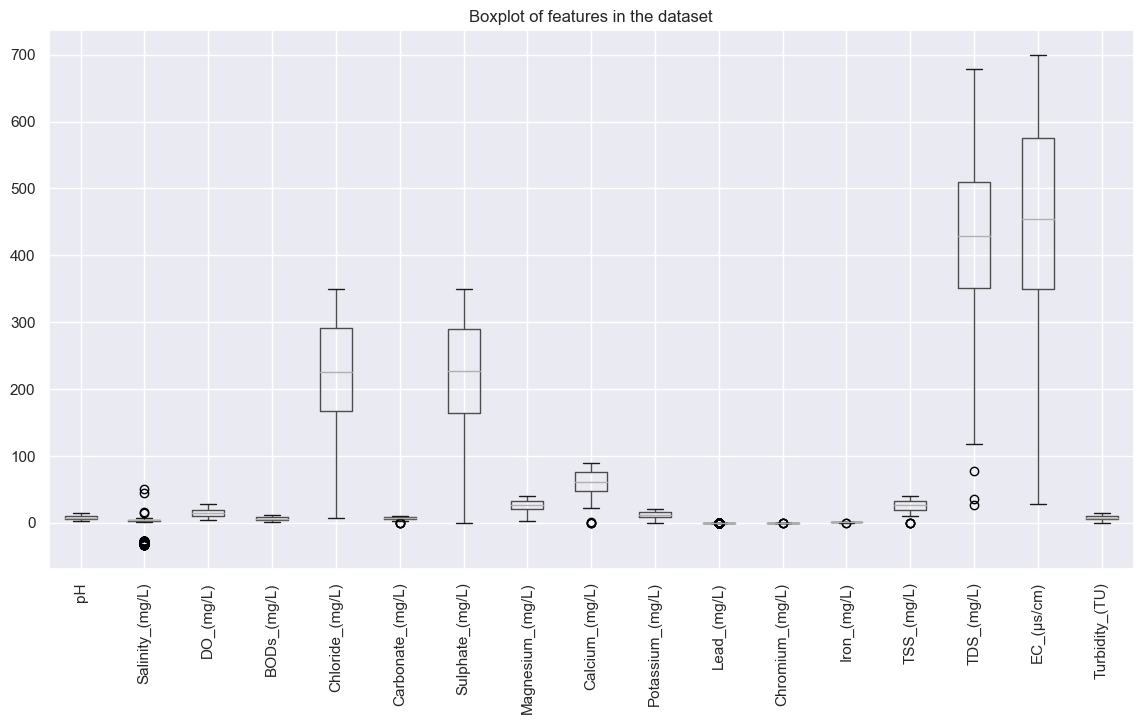

In [207]:

data.boxplot(figsize=(14,7))
plt.title('Boxplot of features in the dataset')
plt.xticks(rotation=90)
plt.show()

Handling Outliers

In [208]:
# #Using the quartile range to isolate outliers

# Q1 = data.quantile(0.25)
# Q3 = data.quantile(0.75)
# IQR =Q3-Q1
# outliers = ((data < (Q1 - 1.5 * IQR))) | (data> (Q3 + 1.5 * IQR)).any(axis=1)

# data = data[~outliers]

# data[:5]

In [209]:
#Using the Z-Score approach to handle outliers

from scipy import stats

z_scores = stats.zscore(data)
threshold = 3
outliers = (z_scores > threshold).any(axis=1)

# for col in data.columns:
#     median = data[col].median()
#     data.loc[outliers, col] = median

data = data[~outliers]

data.head()

,pH,Salinity_(mg/L),DO_(mg/L),BODs_(mg/L),Chloride_(mg/L),Carbonate_(mg/L),Sulphate_(mg/L),Magnesium_(mg/L),Calcium_(mg/L),Potassium_(mg/L),Lead_(mg/L),Chromium_(mg/L),Iron_(mg/L),TSS_(mg/L),TDS_(mg/L),EC_(µs/cm),Turbidity_(TU)
2,5.50,16.00,6.50,1.06,6.92,0.00,0.00,2.464,0.000,0.552,0.00,0.00,0.116,0.02,35.00,68.00,0.00
3,5.90,15.00,6.50,1.03,6.92,0.00,0.00,4.439,0.215,0.122,0.00,0.00,0.187,0.04,27.00,46.00,0.00
4,9.77,2.86,11.29,8.62,210.51,7.87,324.23,28.130,60.000,17.890,0.01,0.05,1.000,21.66,426.08,630.37,8.06
5,3.89,3.72,9.54,4.22,244.27,8.14,153.12,20.050,41.840,8.150,0.01,0.04,1.070,21.08,394.11,621.76,6.45
6,8.83,2.11,18.22,4.04,164.36,8.45,208.91,20.870,75.200,14.230,0.01,0.03,1.230,25.27,403.65,470.67,7.30


In [210]:
data.isna().sum()

pH                  0
Salinity_(mg/L)     0
DO_(mg/L)           0
BODs_(mg/L)         0
Chloride_(mg/L)     0
Carbonate_(mg/L)    0
Sulphate_(mg/L)     0
Magnesium_(mg/L)    0
Calcium_(mg/L)      0
Potassium_(mg/L)    0
Lead_(mg/L)         0
Chromium_(mg/L)     0
Iron_(mg/L)         0
TSS_(mg/L)          0
TDS_(mg/L)          0
EC_(µs/cm)          0
Turbidity_(TU)      0
dtype: int64

In [211]:
#fill the missing values with their mean.
data = data.fillna(data.mean())

Check for missing values

In [212]:
check_missing = data.isnull().sum() * 100/data.shape[0]
check_missing[check_missing > 0].sort_values(ascending=False)

Series([], dtype: float64)

Correlation plot


In [213]:
correlation = data.corr()
correlation['pH'].sort_values(ascending=False)

pH                  1.000000
DO_(mg/L)           0.066768
BODs_(mg/L)         0.041888
Turbidity_(TU)      0.027416
Lead_(mg/L)         0.017828
Sulphate_(mg/L)     0.003053
Salinity_(mg/L)    -0.001003
Chloride_(mg/L)    -0.008371
Magnesium_(mg/L)   -0.028486
EC_(µs/cm)         -0.040514
Chromium_(mg/L)    -0.042385
Iron_(mg/L)        -0.044161
Potassium_(mg/L)   -0.055459
TSS_(mg/L)         -0.057906
Carbonate_(mg/L)   -0.064230
Calcium_(mg/L)     -0.066436
TDS_(mg/L)         -0.068547
Name: pH, dtype: float64

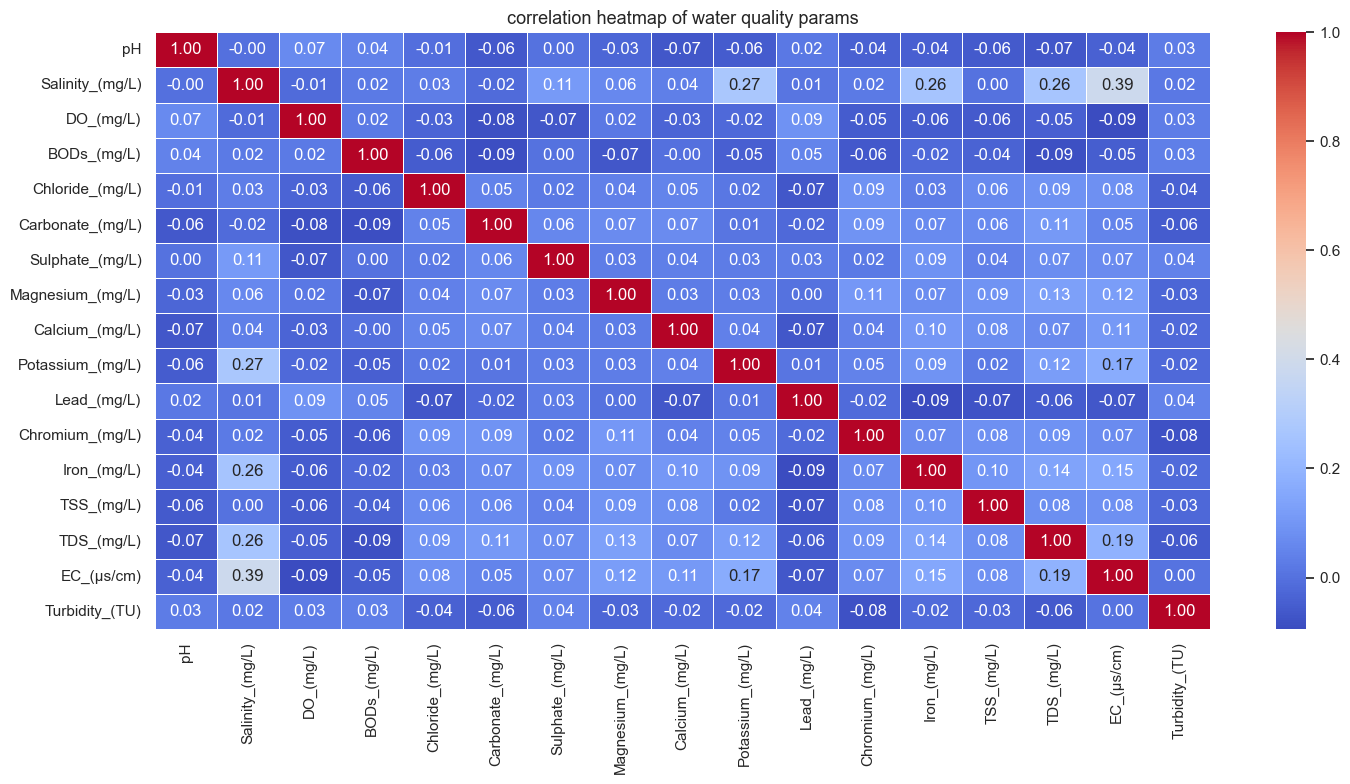

In [214]:
#data.drop(columns=['Carbonate_(mg/L)','Mecury_(mg/L)'], inplace=True)

plt.figure(figsize=(15,8))
sns.heatmap(data.corr(), linewidths=0.5, annot=True, fmt=".2f", cmap='coolwarm')
plt.title('correlation heatmap of water quality params', fontsize=13)

plt.tight_layout()
plt.show()

**Data preprocessing**

In [215]:
#import libraries
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans, DBSCAN, AgglomerativeClustering
from scipy.cluster.hierarchy import linkage
from skopt import BayesSearchCV
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import silhouette_score, make_scorer
from sklearn.model_selection import cross_val_score

import warnings
warnings.filterwarnings('ignore')


In [216]:
#standardize the data
scaler = StandardScaler()
X_scaled = pd.DataFrame(scaler.fit_transform(data), columns=data.columns)

X_scaled[:5]



,pH,Salinity_(mg/L),DO_(mg/L),BODs_(mg/L),Chloride_(mg/L),Carbonate_(mg/L),Sulphate_(mg/L),Magnesium_(mg/L),Calcium_(mg/L),Potassium_(mg/L),Lead_(mg/L),Chromium_(mg/L),Iron_(mg/L),TSS_(mg/L),TDS_(mg/L),EC_(µs/cm),Turbidity_(TU)
0,-0.712098,1.404331,-1.520807,-2.212054,-2.988687,-3.777140,-3.065688,-3.117833,-3.411647,-2.623563,-2.510600,-3.750989,-3.117198,-3.275616,-3.606605,-2.645212,-2.568305
1,-0.574310,1.320793,-1.520807,-2.224290,-2.988687,-3.777140,-3.065688,-2.863101,-3.399541,-2.722896,-2.510600,-3.750989,-2.824285,-3.273117,-3.680760,-2.796415,-2.568305
2,0.758789,0.306637,-0.681531,0.871367,-0.211930,0.465682,1.330758,0.192530,-0.033137,1.381620,-0.213825,1.541427,0.529775,-0.571295,0.018483,1.219890,0.198258
3,-1.266694,0.378480,-0.988156,-0.923217,0.248522,0.611242,-0.989434,-0.849617,-1.055700,-0.868379,-0.213825,0.482944,0.818563,-0.643777,-0.277861,1.160715,-0.354368
4,0.434987,0.243983,0.532702,-0.996632,-0.841368,0.778367,-0.232941,-0.743854,0.822752,0.536138,-0.213825,-0.575540,1.478648,-0.120158,-0.189431,0.122291,-0.062609


In [217]:
X_scaled.shape

(2492, 17)

In [218]:

X = np.array(X_scaled).reshape(-1,1)

X.shape

(42364, 1)

In [219]:
#do this to save memory        
#del data, data_merged, aquifer_physiochem

Hyperparameter for cluster algorithm

In [168]:
#model selection for clustering       
model_params = {  
    'DBSCAN': {
        'model': DBSCAN(),
        'params': {
            'eps': list(np.arange(0.1, 1.0, 0.01)),
            'min_samples': list(range(3, 21))
        },
        'scoring': silhouette_score
    },
    'AgglomerativeClustering': {
        'model': AgglomerativeClustering(),
        'params': {
            'n_clusters': list(range(2, 5)),
            'linkage': ['ward', 'complete', 'average'],
            'metric': ['euclidean']
        },
        'scoring': silhouette_score
    }
}
        
#finding the best cluster estimator
best_estimators = {}
for model_name, params in model_params.items():
    try:
        model = params['model']
        param_grid = params['params']
        scoring = params['scoring']
        
        grid_search = GridSearchCV(model, param_grid, scoring=scoring)
        grid_search.fit(X_scaled)

         
        best_estimators[model_name] = grid_search.best_estimator_
        print(f'Best estimators {model_name}: {grid_search.best_estimator_}')
       
    except Exception as e:
        print(f'Error occured in Hyperparameter tuning {model_name}: {str(e)}')
        
        

Best estimators DBSCAN: DBSCAN(eps=0.1, min_samples=3)
Best estimators AgglomerativeClustering: AgglomerativeClustering(metric='euclidean')


**CLustering analysis**

Model development

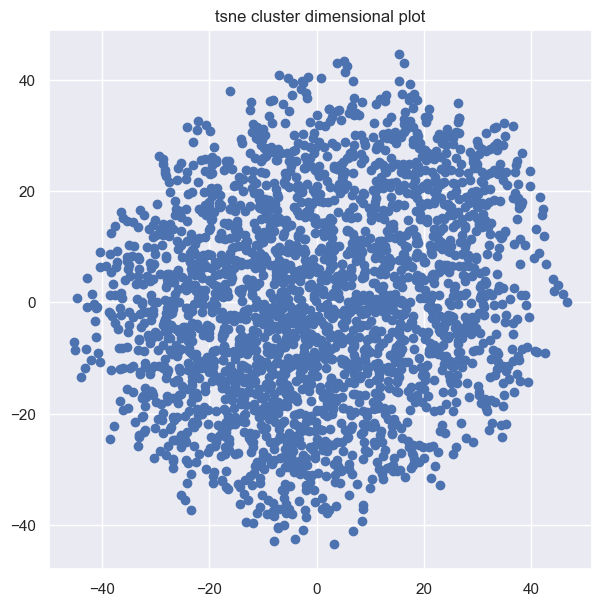

In [262]:
from sklearn.manifold import TSNE

"""
I will be using T-distributed Stochastic Neighbor Embedding. It helps in visualizing high dimensional
data. It converts similarities between data points to joint probabilities and tries to
minimize the values to low-dimensional embedding.
"""

tsne_model = TSNE(n_components=3, random_state=10)
tsne_df = tsne_model.fit_transform(X_scaled)

plt.figure(figsize=(7,7))
plt.scatter(tsne_df[:,0], tsne_df[:,1])
plt.title('tsne cluster dimensional plot')
plt.show()


In [221]:
error = []

for n_clusters in range(1, 21):
    KM_model = KMeans(init='k-means++', n_clusters=n_clusters, max_iter=500, random_state=42)
    KM_model.fit(X_scaled)
    
    error.append(KM_model.inertia_)

Here inertia is simply the sum of squared distances within the clusters.

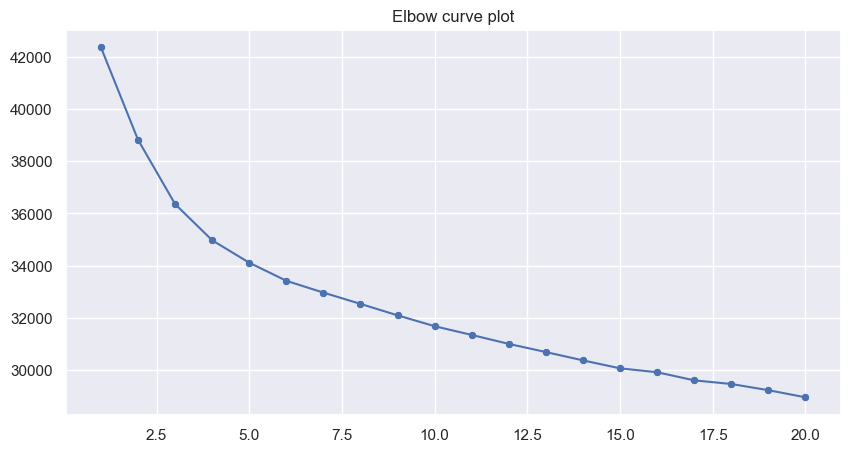

In [263]:
plt.figure(figsize=(10,5))
sns.lineplot(x=range(1,21), y=error)
sns.scatterplot(x=range(1,21), y=error)

plt.title('Elbow curve plot')
plt.grid(True)
plt.show()

Using the elbow method we can ascertain the k = 5, is the optimal number of clusters that should be made as after k= 5, thee value of the inertia is not decreasing drastically.

- KMeans Clustering


In [223]:
KM_model = KMeans(init='k-means++', n_clusters=4, max_iter=500, random_state=42)

vulnerability = KM_model.fit_predict(X_scaled)

In [224]:
print(f"Shape of tsne_df: {tsne_df.shape}")
print(f"Length of vulnerability: {len(vulnerability)}")


Shape of tsne_df: (2492, 3)
Length of vulnerability: 2492


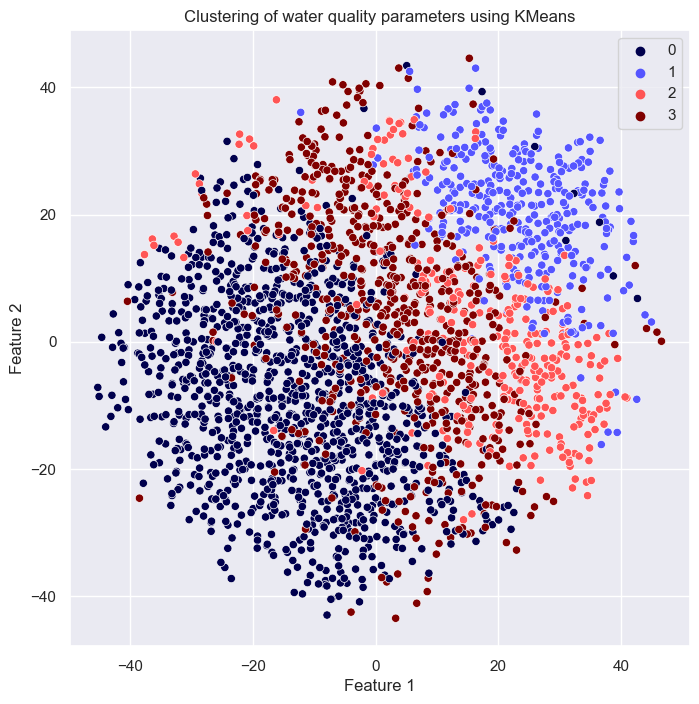

In [264]:
plt.figure(figsize=(8,8))
sns.set(style="darkgrid")
sns.scatterplot(x=tsne_df[:,0], y=tsne_df[:,1], hue=vulnerability, palette='seismic')
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.title('Clustering of water quality parameters using KMeans')

plt.show()

- **Agglomerative Clustering**

In [236]:

Agglo_Model = AgglomerativeClustering(n_clusters=3, linkage='ward', metric='euclidean')

agglo_vulnerability = Agglo_Model.fit_predict(X_scaled)

In [237]:
print(f"Shape of tsne_df: {tsne_df.shape}")
print(f"Length of vulnerability: {len(agglo_vulnerability)}")

Shape of tsne_df: (2492, 3)
Length of vulnerability: 2492


In [238]:
#Evaluating the clustering model
from sklearn.metrics import silhouette_score, calinski_harabasz_score, davies_bouldin_score

silhouette_avg = silhouette_score(X_scaled, agglo_vulnerability).round(3)
calinski_harabasz = calinski_harabasz_score(X_scaled, agglo_vulnerability).round(3)
davies_bouldin = davies_bouldin_score(X_scaled, agglo_vulnerability).round(3)

print("Silhouette Score: ", silhouette_avg)
print("Calinski-Harabasz Index: ", calinski_harabasz)
print("Davies-Bouldin Index: ", davies_bouldin)


Silhouette Score:  0.057
Calinski-Harabasz Index:  132.258
Davies-Bouldin Index:  3.435


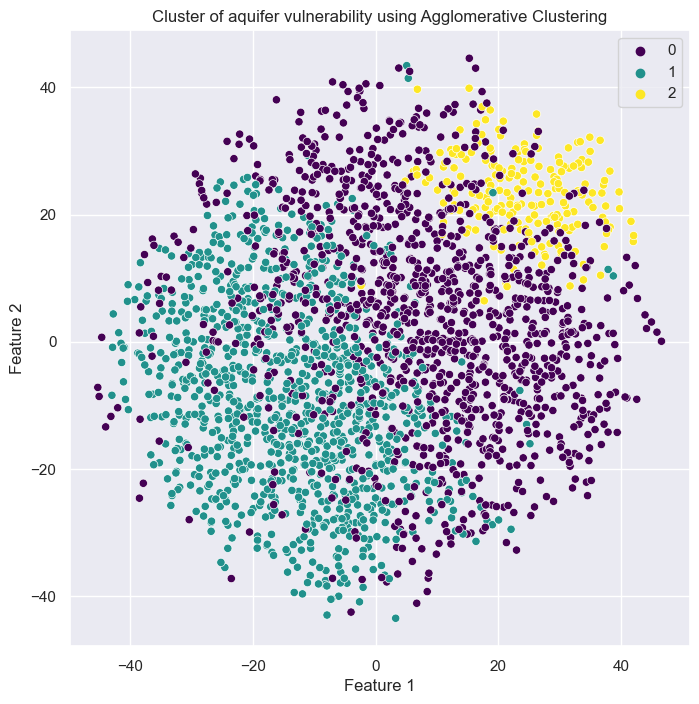

In [257]:
plt.figure(figsize=(8,8))
sns.set(style="darkgrid")
sns.scatterplot(x=tsne_df[:,0], y=tsne_df[:,1], hue=agglo_vulnerability, palette='viridis')
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.title('Cluster of aquifer vulnerability using Agglomerative Clustering')

plt.show()

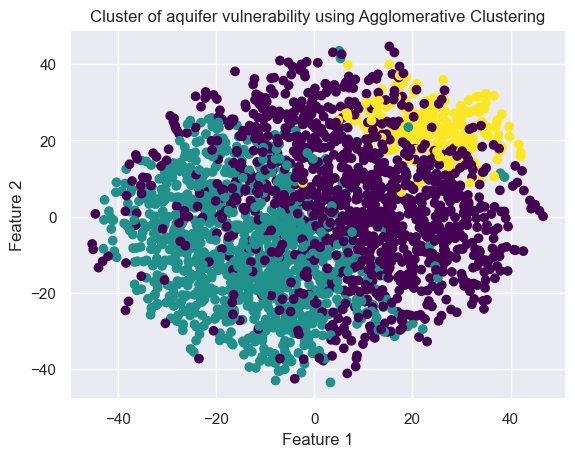

In [258]:
# Visualizing the data points

plt.scatter(tsne_df[:, 0], tsne_df[:, 1], c=agglo_vulnerability, cmap='viridis')
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.title('Cluster of aquifer vulnerability using Agglomerative Clustering')

plt.show()

##### **Advanced Clustering algorithms**

- Gaussian Mixture algorithm

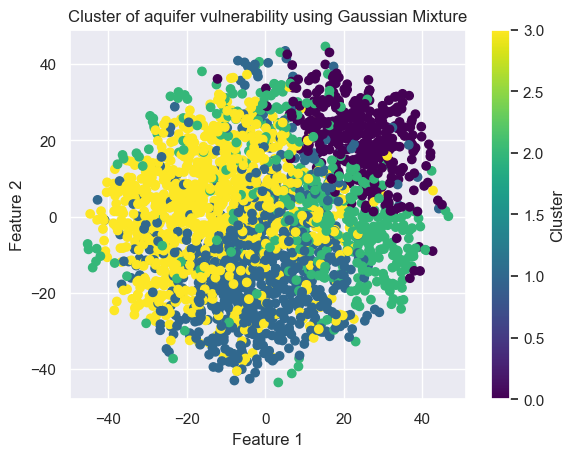

In [260]:
from sklearn.mixture import GaussianMixture

# Fit the model
gmm = GaussianMixture(n_components=4, random_state=42)
gmm.fit(X_scaled)
gmm_labels = gmm.predict(X_scaled)

# Visualizing the data points
plt.scatter(tsne_df[:, 0], tsne_df[:, 1], c=gmm_labels, cmap='viridis',)
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.title('Cluster of aquifer vulnerability using Gaussian Mixture')
plt.colorbar(label='Cluster')
plt.show()


In [243]:
#Evaluating GMM
silhouette_avg = silhouette_score(X_scaled, gmm_labels).round(3)
calinski_harabasz = calinski_harabasz_score(X_scaled, gmm_labels).round(3)
davies_bouldin = davies_bouldin_score(X_scaled, gmm_labels).round(3)

print("Silhouette Score: ", silhouette_avg)
print("Calinski-Harabasz Index: ", calinski_harabasz)
print("Davies-Bouldin Index: ", davies_bouldin)


Silhouette Score:  0.036
Calinski-Harabasz Index:  124.344
Davies-Bouldin Index:  4.08


- **Spectral Clustering**

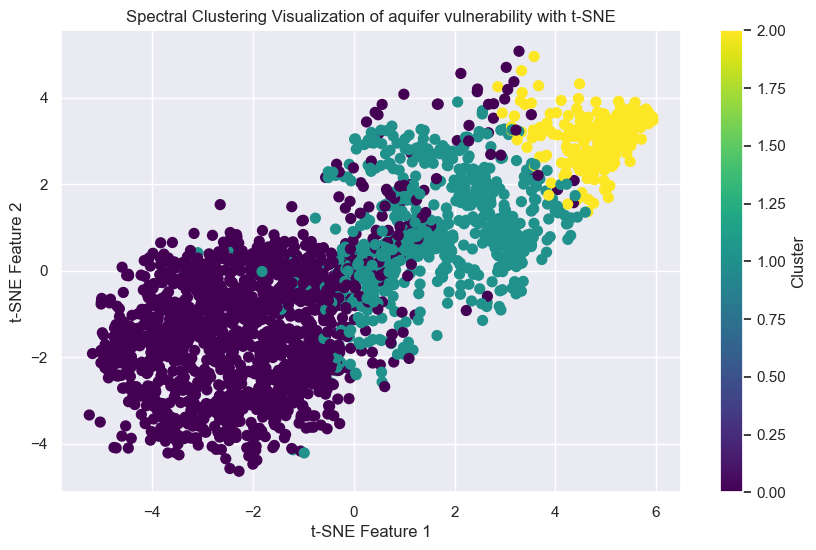

In [261]:
from sklearn.cluster import SpectralClustering

# Spectral Clustering
spectral_model = SpectralClustering(n_clusters=3, affinity='nearest_neighbors', random_state=42)
spectral_labels = spectral_model.fit_predict(X_scaled)

# t-SNE for Visualization
tsne = TSNE(n_components=2, perplexity=30, n_iter=300, random_state=42)
tsne_results = tsne.fit_transform(X_scaled)

# Plotting the results
plt.figure(figsize=(10, 6))
plt.scatter(tsne_results[:, 0], tsne_results[:, 1], c=spectral_labels, cmap='viridis', s=50)
plt.title('Spectral Clustering Visualization of aquifer vulnerability with t-SNE')
plt.xlabel('t-SNE Feature 1')
plt.ylabel('t-SNE Feature 2')
plt.colorbar(label='Cluster')
plt.show()


In [245]:
#Evaluating spectral clustering
silhouette_avg = silhouette_score(X_scaled, spectral_labels).round(3)
calinski_harabasz = calinski_harabasz_score(X_scaled, spectral_labels).round(3)
davies_bouldin = davies_bouldin_score(X_scaled, spectral_labels).round(3)

print("Silhouette Score: ", silhouette_avg)
print("Calinski-Harabasz Index: ", calinski_harabasz)
print("Davies-Bouldin Index: ", davies_bouldin)


Silhouette Score:  0.119
Calinski-Harabasz Index:  188.794
Davies-Bouldin Index:  3.101


### **CONCLUSION**


#### Clustering Evaluation Metrics Overview

The clustering evaluation metrics provide valuable insights into the performance and effectiveness of different clustering models used to analyze aquifer vulnerability to leachate contamination. Below are the updated metrics for each model:

#### Agglomerative Clustering
- **Silhouette Score**: 0.057
  - Indicates a low level of cluster separation.
- **Calinski-Harabasz Index**: 132.258
  - Suggests moderate clustering structure.
- **Davies-Bouldin Index**: 3.435
  - Implies some overlap between clusters, indicating room for improvement.

#### Gaussian Mixture Model
- **Silhouette Score**: 0.036
  - Reflects poor cluster separation, suggesting the model struggles to distinctly define clusters.
- **Calinski-Harabasz Index**: 124.344
  - Points to a less effective clustering structure compared to other models.
- **Davies-Bouldin Index**: 4.08
  - Indicates relatively high intra-cluster similarity, which is undesirable for effective clustering.

#### Spectral Clustering
- **Silhouette Score**: 0.119
  - Represents the best score among the models, suggesting better separation and compactness of clusters.
- **Calinski-Harabasz Index**: 188.794
  - The highest among the models, indicating a well-defined cluster structure.
- **Davies-Bouldin Index**: 3.101
  - Shows the lowest value among the models, suggesting better cluster separation and distinctiveness.

### Interpretation of Metrics

The Silhouette Score evaluates how similar an object is to its own cluster compared to other clusters. Scores closer to +1 indicate a strong match to its own cluster and poor matching to neighboring clusters, while scores near 0 suggest proximity to the decision boundary between clusters. Negative values might indicate incorrect cluster assignments.

The Calinski-Harabasz Index measures the ratio of the sum of between-cluster dispersion to within-cluster dispersion, where higher values generally indicate better-defined clusters.

The Davies-Bouldin Index evaluates the average similarity ratio of each cluster with its most similar cluster, where lower scores indicate better clustering by showing that clusters are well-separated and compact.

### Summary

- **Silhouette Scores**:
  - **Best Performance**: Spectral Clustering (0.119)
  - **Worst Performance**: Gaussian Mixture Model (0.036)

- **Calinski-Harabasz Index**:
  - **Best Performance**: Spectral Clustering (188.794)
  - **Worst Performance**: Gaussian Mixture Model (124.344)

- **Davies-Bouldin Index**:
  - **Best Performance**: Spectral Clustering (3.101)
  - **Worst Performance**: Gaussian Mixture Model (4.08)

Overall, Spectral Clustering outperforms the other models in terms of cluster separation, compactness, and structure. Agglomerative Clustering and Gaussian Mixture Model may require further parameter tuning or different preprocessing techniques to enhance their clustering outcomes. This analysis underscores the need for careful selection and tuning of clustering algorithms to effectively analyze and interpret complex environmental data.

##### **Overlaying the clustering result on the coordinate.**

In [277]:
    """creating a dataframe for the predicted clusters with coordinate using the best performing algorithm. (Spectral Clustering)
    """
    
final_df = ves_coordinates.copy()
final_df['Predicted cluster'] = spectral_labels[:10] 

final_df.head()

,Station,Elevation (ft),Coordinate East,Coordinate North,Predicted cluster
0,1,159,6.784444,6.101667,1
1,2,146,6.783611,6.100833,1
2,3,150,6.801944,6.100278,0
3,4,162,6.784722,6.100278,0
4,5,36,6.784444,6.101944,0


In [276]:
map_center = [
    (ves_coordinates['Coordinate North'].mean() + ves_coordinates['Coordinate North'].min()) / 2 , 
    (ves_coordinates['Coordinate East'].mean() + ves_coordinates['Coordinate East'].min()) / 2
    ]

map_object = folium.Map(location=map_center, zoom_start=12)

# Add a marker cluster to the map
marker_cluster = MarkerCluster().add_to(map_object)

# Define a color map for clusters
color_map = {0: 'blue', 1: 'green', 2: 'red', 3: 'purple', 4: 'orange'}

# Add markers to the map
for idx, row in final_df.iterrows():
    folium.Marker(
        location=[row['Coordinate North'], row['Coordinate East']],
        popup=f"Cluster: {row['Predicted cluster']}, Elevation:{row['Elevation (ft)']} ft",
        icon=folium.Icon(color=color_map.get(row['Predicted cluster'], 'gray'))
    ).add_to(marker_cluster)

# Save the map
map_object.save('C:/Users/admin/Documents/Manuscript/Aquifer-vulnerability/image/clustered_map.html')

# Display the map 
map_object